# Example of using XGBoost to Predict Sales for Supermarket

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from datetime import date, timedelta
from subprocess import check_output
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import scale
from datetime import timedelta
import datetime
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

dtypes = {'store_nbr': np.dtype('int64'),
          'item_nbr': np.dtype('int64'),
          'unit_sales': np.dtype('float64'),
          'onpromotion': np.dtype('O'),
          'transactions':np.dtype('float64')
           }

df_train = pd.read_csv('train.csv', dtype=dtypes, parse_dates=['date'], skiprows=range(1, 86672217)) #Skip dates before 2016-08-01
df_train['dow'] = df_train['date'].dt.dayofweek
df_train.loc[(df_train.unit_sales<0),'unit_sales'] = 0 # eliminate negatives
df_train['unit_sales'] =  df_train['unit_sales'].apply(pd.np.log1p) #logarithm conversion
#df_train[['unit_sales']] = MinMaxScaler().fit_transform(df_train[['unit_sales']])
df_train['onpromotion'].fillna(0, inplace=True)

date_mask = (df_train['date'] >= '2017-06-15') & (df_train['date'] <= '2017-08-15')
train = df_train[date_mask]
len(train)
dummy = pd.get_dummies(train['onpromotion'], prefix='onprom', drop_first = True)
train = pd.concat([train, dummy], axis = 1)
trains=train.drop('onpromotion', axis=1)
trains['year'] = pd.DatetimeIndex(trains['date']).year
trains['month']=pd.DatetimeIndex(trains['date']).month
trains['day']=trains['date'].dt.day
trains.head()

test = pd.read_csv('test.csv', dtype=dtypes)
print('max date:', test['date'].max()) #2017-08-31
print('min date:', test['date'].min()) #2017-08-16

Using TensorFlow backend.


max date: 2017-08-31
min date: 2017-08-16


In [2]:
#prep test data
test = pd.read_csv('test.csv', dtype=dtypes, parse_dates=['date'])
test['dow'] = test['date'].dt.dayofweek
#df_train[['unit_sales']] = MinMaxScaler().fit_transform(df_train[['unit_sales']])
test['onpromotion'].fillna(0, inplace=True)

dummy = pd.get_dummies(test['onpromotion'], prefix='onprom', drop_first = True)
test = pd.concat([test, dummy], axis = 1)
tests=test.drop('onpromotion', axis=1)
tests['year'] = pd.DatetimeIndex(tests['date']).year
tests['month']=pd.DatetimeIndex(tests['date']).month
tests['day']=tests['date'].dt.day
tests.head()
print('max date:', test['date'].max()) #2017-08-31
print('min date:', test['date'].min()) #2017-08-16


max date: 2017-08-31 00:00:00
min date: 2017-08-16 00:00:00


In [66]:
#prep items data
items=pd.read_csv('items.csv' )
items_c=pd.get_dummies(items, drop_first=True)
items_c["perishable"]=items_c["perishable"]*0.25+1
items_c.head()


,item_nbr,class,perishable,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,96995,1093,1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,99197,1067,1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,103501,3008,1.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,103520,1028,1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,103665,2712,1.25,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
weight=items["perishable"] * 0.25 + 1

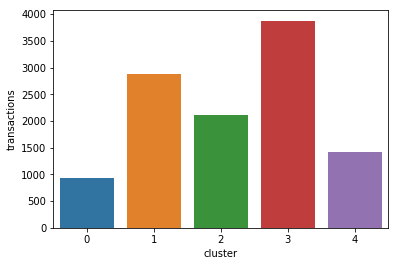

In [4]:
#prep transaction data and create store clusters
trans = pd.read_csv('transactions.csv' )
trans.head()

from sklearn.datasets import make_blobs
plt.figure(figsize=(12,12))
matrix=trans.pivot_table(index=['store_nbr'], values='transactions')
matrix=matrix.fillna(0).reset_index()
x_cols=matrix.columns[1:]
x_cols
cluster=KMeans(n_clusters=5)
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[1:]])
matrix.cluster.value_counts()

matrix.head()
pc=(matrix.groupby(['cluster']).mean())
fig, ax=plt.subplots()
ax=sns.barplot(x=pc.index, y="transactions", data=pc)
plt.show()

In [84]:

#process the hols file
hols=pd.read_csv('holidays_events.csv', usecols=[0,1,2,5], parse_dates=["date"],  dtype={'transferred':bool})
hols_c=pd.get_dummies(hols, drop_first=True)
hols_c.head()

#add missing dates
#min_date=min(train.date)
#max_date=max(train.date)

calen=[]
d1=datetime.datetime.strptime('2016-08-15', '%Y-%m-%d') 
d2=datetime.datetime.strptime('2017-08-31', '%Y-%m-%d')
delta=d2-d1

for i in range(delta.days+1):
    calen.append(datetime.date.strftime(d1+timedelta(days=i), '%Y-%m-%d'))
    
calen=pd.DataFrame({'date':calen})
calen['date']  = pd.to_datetime(calen['date'])

#merge calendar with df_hols
df_hols=calen.merge(hols_c, left_on='date',  right_on='date', how='left')
df_hols['transferred']=df_hols['transferred']*1.0
df_hols.fillna(0, inplace=True)

#print(df_hols.isnull().sum(), '\n')
#print('Type : ', '\n', df_hols.dtypes)

df_hols

,date,transferred,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional
0,2016-08-15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2016-08-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-08-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-08-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2016-08-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2016-08-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2016-08-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2016-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2016-08-24,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [114]:
import calendar as cal
from calendar import monthrange
payday=calen[['date']].copy()
payday['year']=pd.DatetimeIndex(payday['date']).year
payday['month']=pd.DatetimeIndex(payday['date']).month
payday['day']=pd.DatetimeIndex(payday['date']).day
def f(row):
    if row['day'] == 15 :
        val = 1
    else:
        val = 0
    return val
payday['every_15th'] = payday.apply(f, axis=1)

payday.head()

,date,year,month,day,every_15th
0,2016-08-15,2016,8,15,1
1,2016-08-16,2016,8,16,0
2,2016-08-17,2016,8,17,0
3,2016-08-18,2016,8,18,0
4,2016-08-19,2016,8,19,0


In [69]:
#process the oil data
oil = pd.read_csv('oil.csv', usecols=[0,1], parse_dates=["date"] )
#use calendar df from the hols prep 

oil = calendar.merge(oil, left_on='date', right_on='date', how='left')

#Check how many NA
print(oil.isnull().sum(), '\n')
print('Type : ', '\n', oil.dtypes)
oil.head()

date            0
dcoilwtico    118
dtype: int64 

Type :  
 date          datetime64[ns]
dcoilwtico           float64
dtype: object


,date,dcoilwtico
0,2016-08-15,45.72
1,2016-08-16,46.57
2,2016-08-17,46.81
3,2016-08-18,48.20
4,2016-08-19,48.48


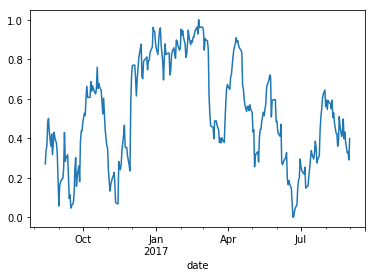

In [70]:
#Check index to apply the formula
na_index_oil = oil[oil['dcoilwtico'].isnull() == True].index.values

#Define the index to use to apply the formala
na_index_oil_plus = na_index_oil.copy()
na_index_oil_minus = np.maximum(0, na_index_oil-1)

for i in range(len(na_index_oil)):
    k = 1
    while (na_index_oil[min(i+k,len(na_index_oil)-1)] == na_index_oil[i]+k):
        k += 1
    na_index_oil_plus[i] = min(len(oil)-1, na_index_oil_plus[i] + k )

#Apply the formula
for i in range(len(na_index_oil)):
    if (na_index_oil[i] == 0):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_plus[i], 'dcoilwtico']
    elif (na_index_oil[i] == len(oil)):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_minus[i], 'dcoilwtico']
    else:
        oil.loc[na_index_oil[i], 'dcoilwtico'] = (oil.loc[na_index_oil_plus[i], 'dcoilwtico'] + oil.loc[na_index_oil_minus[i], 'dcoilwtico'])/ 2    

oil['dcoilwtico'].ffill (inplace=True)
oil.tail()
oil[['dcoilwtico']] = MinMaxScaler().fit_transform(oil[['dcoilwtico']])
#Plot the oil values
oil_plot = oil['dcoilwtico'].copy()
oil_plot.index = oil['date'].copy()
oil_plot.plot()
plt.show()

In [8]:
stores=pd.read_csv('stores.csv', usecols=[0,1,3,4])
stores.head()

,store_nbr,city,type,cluster
0,1,Quito,D,13
1,2,Quito,D,13
2,3,Quito,D,8
3,4,Quito,D,9
4,5,Santo Domingo,D,4


In [9]:
#prep the stores data
stores=pd.read_csv('stores.csv')
stores_c=pd.get_dummies (stores, drop_first=True)
stores_c.head()


,store_nbr,cluster,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,...,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,type_B,type_C,type_D,type_E
0,1,13,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2,13,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,3,8,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,4,9,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,5,4,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [10]:
# merge the data
#Merge train
pd_train = trains.drop('id', axis = 1)
pd_train = pd_train.merge(stores_c, left_on='store_nbr', right_on='store_nbr', how='left')
pd_train = pd_train.merge(items_c, left_on='item_nbr', right_on='item_nbr', how='left')
pd_train = pd_train.merge(df_hols, left_on='date', right_on='date', how='left')
pd_train = pd_train.merge(oil, left_on='date', right_on='date', how='left')
pd_train = pd_train.merge(matrix, left_on='store_nbr', right_on='store_nbr', how='left')
pd_train.head()

,date,store_nbr,item_nbr,unit_sales,dow,onprom_True,year,month,day,cluster_x,...,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,dcoilwtico,transactions,cluster_y
0,2017-06-15,1,99197,1.098612,3,0,2017,6,15,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165833,1523.844272,4
1,2017-06-15,1,103520,0.693147,3,0,2017,6,15,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165833,1523.844272,4
2,2017-06-15,1,103665,0.693147,3,0,2017,6,15,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165833,1523.844272,4
3,2017-06-15,1,105574,0.693147,3,0,2017,6,15,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165833,1523.844272,4
4,2017-06-15,1,105575,1.386294,3,0,2017,6,15,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165833,1523.844272,4


In [11]:
pd_train.tail()

,date,store_nbr,item_nbr,unit_sales,dow,onprom_True,year,month,day,cluster_x,...,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,dcoilwtico,transactions,cluster_y
6862484,2017-08-15,54,2089339,1.609438,1,0,2017,8,15,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.424167,865.924821,0
6862485,2017-08-15,54,2106464,0.693147,1,1,2017,8,15,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.424167,865.924821,0
6862486,2017-08-15,54,2110456,5.262690,1,0,2017,8,15,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.424167,865.924821,0
6862487,2017-08-15,54,2113914,5.293305,1,1,2017,8,15,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.424167,865.924821,0
6862488,2017-08-15,54,2116416,1.098612,1,0,2017,8,15,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.424167,865.924821,0


In [13]:
df_train = pd.read_csv(
    'train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

df_2017 = df_train.loc[df_train.date>=pd.datetime(2017,1,1)]
promo_2017_train = df_2017.set_index(["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_train.head()

onpromotion                                              \
date                2017-01-01 2017-01-02 2017-01-03 2017-01-04 2017-01-05   
store_nbr item_nbr                                                           
1         96995          False      False      False      False      False   
          99197          False      False      False      False      False   
          103520         False      False      False      False      False   
          103665         False      False      False      False      False   
          105574         False      False       True      False      False   

                                                                           \
date               2017-01-06 2017-01-07 2017-01-08 2017-01-09 2017-01-10   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   
          105574         True      False      False      False      False   

                      ...                                                  \
date                  ...     2017-08-06 2017-08-07 2017-08-08 2017-08-09   
store_nbr item_nbr    ...                                                   
1         96995       ...          False      False      False      False   
          99197       ...          False      False      False      False   
          103520      ...          False      False      False      False   
          103665      ...          False      False      False      False   
          105574      ...          False      False      False      False   

                                                                           \
date               2017-08-10 2017-08-11 2017-08-12 2017-08-13 2017-08-14   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   
          105574        False      False      False      False      False   

                               
date               2017-08-15  
store_nbr item_nbr             
1         96995         False  
          99197         False  
          103520        False  
          103665        False  
          105574        False  

[5 rows x 227 columns]

In [19]:

df_test = pd.read_csv("test.csv", usecols=[0, 1, 2, 3, 4], dtype={'onpromotion': bool}, parse_dates=["date"]  # , date_parser=parser
).set_index(['store_nbr', 'item_nbr', 'date'])

promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
promo_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False        True       False   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False        True       False       False   

date                2017-01-09  2017-01-10     ...      2017-08-22  \
store_nbr item_nbr                             ...                   
1         96995          False       False     ...           False   
          99197          False       False     ...           False   
          103520         False       False     ...           False   
          103665         False       False     ...           False   
          105574         False       False     ...           False   

date                2017-08-23  2017-08-24  2017-08-25  2017-08-26  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-08-27  2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                              
1         96995          False       False       False       False       False  
          99197          False       False       False       False       False  
          103520         False       False       False       False       False  
          103665         False       False       False       False       False  
          105574         False       False       False       False       False  

[5 rows x 243 columns]

In [20]:
df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)
df_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995            0.0    0.000000    0.000000    0.000000   
          99197            0.0    0.000000    1.386294    0.693147   
          103520           0.0    0.693147    1.098612    0.000000   
          103665           0.0    0.000000    0.000000    1.386294   
          105574           0.0    0.000000    1.791759    2.564949   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.693147    0.693147    1.098612    0.000000   
          103520      1.098612    1.386294    0.693147    0.000000   
          103665      1.098612    1.098612    0.693147    1.098612   
          105574      2.302585    1.945910    1.609438    1.098612   

date                2017-01-09  2017-01-10     ...      2017-08-06  \
store_nbr item_nbr                             ...                   
1         96995       0.000000    0.000000     ...        1.098612   
          99197       0.000000    0.693147     ...        0.000000   
          103520      0.693147    0.693147     ...        0.000000   
          103665      0.000000    2.079442     ...        0.693147   
          105574      1.386294    2.302585     ...        0.000000   

date                2017-08-07  2017-08-08  2017-08-09  2017-08-10  \
store_nbr item_nbr                                                   
1         96995       1.098612    0.000000    0.000000    0.693147   
          99197       1.098612    0.000000    1.098612    0.000000   
          103520      0.000000    1.386294    0.000000    1.386294   
          103665      1.098612    0.000000    2.079442    2.302585   
          105574      1.791759    2.079442    1.945910    2.397895   

date                2017-08-11  2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                              
1         96995       0.000000    0.000000    0.000000    0.000000    0.000000  
          99197       0.000000    0.000000    0.000000    0.000000    0.000000  
          103520      0.693147    0.693147    0.693147    0.000000    0.000000  
          103665      1.098612    0.000000    0.000000    0.693147    0.693147  
          105574      1.791759    1.791759    0.000000    1.386294    1.609438  

[5 rows x 227 columns]

In [21]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [26]:
t2017 = date(2017, 5, 31)
X = pd.DataFrame({
        "day_1_2017": get_timespan(df_2017, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        #"mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        #"mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        #"mean_30_2017": get_timespan(df_2017, t2017, 30, 30).mean(axis=1).values,
        #"mean_60_2017": get_timespan(df_2017, t2017, 60, 60).mean(axis=1).values,
        #"mean_140_2017": get_timespan(df_2017, t2017, 140, 140).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        #"promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values
    })
X.head()

,day_1_2017,mean_3_2017,promo_14_2017,promo_60_2017
0,0.000000,0.231049,0,0
1,0.000000,0.597253,0,0
2,0.000000,0.000000,0,0
3,0.000000,0.366204,0,0
4,1.098612,1.059351,0,21


In [28]:
i=5
X['mean_4_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 28-i, 4, freq='7D').mean(axis=1).values
#X['mean_20_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 140-i, 20, freq='7D').mean(axis=1).values
X.head() 

,day_1_2017,mean_3_2017,promo_14_2017,promo_60_2017,mean_4_dow5_2017
0,0.000000,0.231049,0,0,0.173287
1,0.000000,0.597253,0,0,0.447940
2,0.000000,0.000000,0,0,0.621227
3,0.000000,0.366204,0,0,1.098612
4,1.098612,1.059351,0,21,2.125672


In [29]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "day_1_2017": get_timespan(df_2017, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(df_2017, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(df_2017, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(df_2017, t2017, 140, 140).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values
    })
    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [35]:
def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "day_1_2017": get_timespan(df_2017, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(df_2017, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(df_2017, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(df_2017, t2017, 140, 140).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values
    })
    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X


In [37]:
X.head()

,day_1_2017,mean_3_2017,promo_14_2017,promo_60_2017,mean_4_dow5_2017,promo_10,promo_1,promo_16
0,0.000000,0.231049,0,0,0.173287,0,0,0
1,0.000000,0.597253,0,0,0.447940,0,0,0
2,0.000000,0.000000,0,0,0.621227,0,0,0
3,0.000000,0.366204,0,0,1.098612,0,0,0
4,1.098612,1.059351,0,21,2.125672,0,0,0


In [45]:
t2017 = date(2017, 5, 31)
X_l, y_l = [], []
i=2
delta = timedelta(days=7 * i)
X_tmp, y_tmp = prepare_dataset(
        t2017 + delta)
delta
y_tmp


array([[ 0.69314718,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.69314718],
       [ 1.38629436,  1.09861229,  0.        , ...,  1.38629436,
         1.38629436,  0.69314718],
       [ 1.94591015,  0.69314718,  0.69314718, ...,  1.09861229,
         1.38629436,  0.69314718],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [46]:
X_l.append(X_tmp)
X_l
#y_l.append(y_tmp)

[        day_1_2017  mean_140_2017  mean_14_2017  mean_30_2017  mean_3_2017  \
 0         0.000000       0.080058      0.099021      0.115525     0.000000   
 1         0.693147       0.185981      0.864906      0.715765     0.597253   
 2         1.098612       0.744964      0.923954      0.819659     0.828302   
 3         0.693147       1.033945      1.237843      1.078568     1.059351   
 4         1.098612       1.811382      1.742354      1.692422     1.329661   
 5         2.639057       2.267894      2.210792      2.142630     2.013418   
 6         1.386294       0.596473      0.923954      0.675743     0.693147   
 7         0.693147       0.141995      0.247553      0.115525     0.462098   
 8         1.098612       0.888326      1.045884      0.993859     0.963457   
 9         2.484907       1.347814      1.582609      1.777522     2.022809   
 10        1.386294       0.788481      1.009952      0.937905     1.059351   
 11        1.098612       0.601237      0.548419    

In [48]:
y_l.append(y_tmp)
y_l

[array([[ 0.69314718,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.69314718],
        [ 1.38629436,  1.09861229,  0.        , ...,  1.38629436,
          1.38629436,  0.69314718],
        [ 1.94591015,  0.69314718,  0.69314718, ...,  1.09861229,
          1.38629436,  0.69314718],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.69314718,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.69314718],
        [ 1.38629436,  1.09861229,  0.        , ...,  1.38629436,
          1.38629436,  0.69314718],
        [ 1.94591015,  0.69314718,  0.69314718, ...,  1.09861229,
          1.38629436,  0.69314718],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,

In [50]:
X_train = pd.concat(X_l, axis=0)
X_train

,day_1_2017,mean_140_2017,mean_14_2017,mean_30_2017,mean_3_2017,mean_60_2017,mean_7_2017,promo_140_2017,promo_14_2017,promo_60_2017,...,promo_6,promo_7,promo_8,promo_9,promo_10,promo_11,promo_12,promo_13,promo_14,promo_15
0,0.000000,0.080058,0.099021,0.115525,0.000000,0.168492,0.099021,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.693147,0.185981,0.864906,0.715765,0.597253,0.392540,0.683927,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.098612,0.744964,0.923954,0.819659,0.828302,0.877159,0.908015,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.693147,1.033945,1.237843,1.078568,1.059351,1.063562,1.038914,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.098612,1.811382,1.742354,1.692422,1.329661,1.749471,1.784525,34,0,8,...,0,0,0,0,0,0,0,0,0,0
5,2.639057,2.267894,2.210792,2.142630,2.013418,2.151269,2.119297,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.386294,0.596473,0.923954,0.675743,0.693147,0.670948,0.850092,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.693147,0.141995,0.247553,0.115525,0.462098,0.069315,0.297063,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.098612,0.888326,1.045884,0.993859,0.963457,0.903084,1.166927,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2.484907,1.347814,1.582609,1.777522,2.022809,1.601301,1.617989,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [55]:
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)
X_test

,day_1_2017,mean_140_2017,mean_14_2017,mean_30_2017,mean_3_2017,mean_60_2017,mean_7_2017,promo_140_2017,promo_14_2017,promo_60_2017,...,promo_6,promo_7,promo_8,promo_9,promo_10,promo_11,promo_12,promo_13,promo_14,promo_15
0,0.000000,0.153952,0.334438,0.275522,0.000000,0.160866,0.099021,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.376532,0.206455,0.331321,0.000000,0.444620,0.156945,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.821010,0.573577,0.714515,0.231049,0.756274,0.495105,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.693147,1.040541,1.031388,1.017638,0.462098,1.001216,0.980990,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.609438,1.765433,1.629185,1.714960,0.998577,1.686812,1.560437,24,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.197225,2.238009,2.382527,2.356156,2.123871,2.303483,2.304131,0,0,0,...,0,0,1,1,1,1,1,1,1,1
6,1.098612,0.602872,0.474556,0.483466,0.597253,0.524279,0.553029,11,4,11,...,0,1,1,1,1,1,1,0,1,1
7,0.693147,0.155165,0.276514,0.258080,0.693147,0.239770,0.553029,7,0,7,...,0,0,0,0,0,0,0,0,1,0
8,0.000000,0.795222,0.681012,0.688510,0.231049,0.634161,0.553029,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2.708050,1.600535,1.619796,1.592271,1.782369,1.648403,1.520775,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
items = pd.read_csv("items.csv",).set_index("item_nbr")
dtrain = xgb.DMatrix(X_train, label=y_train[:, i], weight=pd.concat([items["perishable"]] * 6) * 0.25 + 1)
dtrain


In [63]:
dval = xgb.DMatrix(
        X_val, label=y_val[:, i],
        weight=items["perishable"] * 0.25 + 1)
dval        


In [64]:
weight=items["perishable"] * 0.25 + 1
weight

item_nbr
96995      1.00
99197      1.00
103501     1.00
103520     1.00
103665     1.25
105574     1.00
105575     1.00
105576     1.00
105577     1.00
105693     1.00
105737     1.00
105857     1.00
106716     1.00
108079     1.00
108634     1.00
108696     1.25
108698     1.25
108701     1.25
108786     1.00
108797     1.00
108831     1.25
108833     1.25
108862     1.00
108952     1.00
111223     1.00
111397     1.00
112830     1.00
114778     1.00
114790     1.00
114799     1.00
           ... 
2127992    1.00
2128628    1.00
2128799    1.00
2129334    1.00
2129350    1.00
2129387    1.00
2129515    1.00
2129616    1.00
2129678    1.00
2129786    1.00
2129790    1.00
2129892    1.00
2129994    1.00
2130131    1.00
2130219    1.00
2130265    1.00
2130352    1.00
2130474    1.00
2130521    1.00
2130526    1.00
2130553    1.00
2131010    1.00
2131572    1.00
2131699    1.00
2132163    1.00
2132318    1.00
2132945    1.00
2132957    1.00
2134058    1.00
2134244    1.00
Name: perishabl

In [ ]:
watchlist = [ (dtrain,'train'), (dval, 'val') ]

In [61]:

y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)

In [62]:
t2017 = date(2017, 5, 31)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)

In [34]:
i=16
X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
X.head()

,day_1_2017,mean_3_2017,promo_14_2017,promo_60_2017,mean_4_dow5_2017,promo_10,promo_1,promo_16
0,0.000000,0.231049,0,0,0.173287,0,0,0
1,0.000000,0.597253,0,0,0.447940,0,0,0
2,0.000000,0.000000,0,0,0.621227,0,0,0
3,0.000000,0.366204,0,0,1.098612,0,0,0
4,1.098612,1.059351,0,21,2.125672,0,0,0


In [30]:
print('Shape : ', pd_train.shape)
pd_train.sample(10)

Shape :  (6862489, 95)


,date,store_nbr,item_nbr,unit_sales,dow,onprom_True,year,month,day,cluster_x,...,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,dcoilwtico,transactions,cluster_y
3397153,2017-07-13,52,1349808,2.564949,3,0,2017,7,13,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298333,2333.838983,2
1764561,2017-06-29,41,1940454,1.098612,3,0,2017,6,29,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,1051.965414,0
4392177,2017-07-23,25,518094,3.465736,6,0,2017,7,23,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.301875,941.400619,0
2660771,2017-07-06,51,1092106,1.655749,3,0,2017,7,6,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.253333,1713.544425,4
4599489,2017-07-25,22,414620,1.791759,1,0,2017,7,25,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440833,751.350224,0
485437,2017-06-19,31,1091368,1.098612,0,0,2017,6,19,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146667,1374.281287,4
2243092,2017-07-03,28,1230060,0.693147,0,0,2017,7,3,10,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.228646,1167.319022,0
3607001,2017-07-15,51,1457000,0.693147,5,0,2017,7,15,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316250,1713.544425,4
4375601,2017-07-23,16,1239916,0.693147,6,0,2017,7,23,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.301875,873.284436,0
498973,2017-06-19,39,1457179,1.791759,0,0,2017,6,19,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146667,1424.005959,4


In [16]:
pd_train=pd_train.drop(['date'], axis=1)

In [18]:
print(pd_train.isnull().sum(), '\n')
print('Type : ', '\n', pd_train.dtypes)


store_nbr                            0
item_nbr                             0
unit_sales                           0
dow                                  0
onprom_True                          0
year                                 0
month                                0
day                                  0
cluster_x                            0
city_Babahoyo                        0
city_Cayambe                         0
city_Cuenca                          0
city_Daule                           0
city_El Carmen                       0
city_Esmeraldas                      0
city_Guaranda                        0
city_Guayaquil                       0
city_Ibarra                          0
city_Latacunga                       0
city_Libertad                        0
city_Loja                            0
city_Machala                         0
city_Manta                           0
city_Playas                          0
city_Puyo                            0
city_Quevedo             

In [19]:
#pd_trains1=pd_trains.sample(20000000)
pd_trains1 = pd_train.reset_index(drop=True)  #we reset the index
y = pd_trains1['unit_sales'].values
X= pd_trains1.drop(['unit_sales'], axis = 1)

print('Shape X :', X.shape)
print('Shape y :', y.shape)

Shape X : (6862489, 93)
Shape y : (6862489,)


In [30]:
#pd_trains.to_csv('pd_train')

KeyboardInterrupt: 

In [20]:
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test, random_state=42)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_validation shape :', X_test.shape)
print('y_validation shape :', y_test.shape)

X_train shape : (5489991, 93)
y_train shape : (5489991,)
X_validation shape : (1372498, 93)
y_validation shape : (1372498,)


In [ ]:
sc=StandardScaler()
X_train=sc.transform(X_train)
x_test=sc.transform(X_test)

In [22]:
#Merge test data
pd_test = tests.drop('id', axis = 1)
pd_test = pd_test.merge(stores_c, left_on='store_nbr', right_on='store_nbr', how='left')
pd_test = pd_test.merge(items_c, left_on='item_nbr', right_on='item_nbr', how='left')
pd_test = pd_test.merge(df_hols, left_on='date', right_on='date', how='left')
pd_test = pd_test.merge(oil, left_on='date', right_on='date', how='left')
pd_test = pd_test.merge(matrix, left_on='store_nbr', right_on='store_nbr', how='left')
pd_test=pd_test.drop(['date'], axis=1)
test_a = sc.transform(pd_test)
test_a

NameError: name 'sc' is not defined

In [25]:
import xgboost as xgb
param = {'bst:max_depth':2, 'bst:eta':1, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'unit_sales'

evallist  = [(y_train,'eval'), (X_train,'train')]

num_round = 10
bst = xgb.train( param, X_train, num_round, evallist )

#gbm = xgboost.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
#predictions = gbm.predict(test_a)

TypeError: invalid cache item: DataFrame

In [ ]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05, verbose=1).fit(X_train, y_train)
predictions = gbm.predict(test_a)

# Kaggle needs the submission to have a certain format;
# see https://www.kaggle.com/c/titanic-gettingStarted/download/gendermodel.csv
# for an example of what it's supposed to look like.
submission = pd.DataFrame({ 'PassengerId': test_df['PassengerId'],
                            'Survived': predictions })
submission.to_csv("submission.csv", index=False)

In [33]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [131]:
n_columns=X.shape[1] 
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(100, kernel_initializer='normal', activation='relu', input_shape = (n_columns,)))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [133]:

seed=6
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=50, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=3, random_state=seed)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

MemoryError: 

In [109]:
pipeline.fit(X_train,y_train) 

models=pipeline.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[early_stopping_monitor], verbose=1) 

Epoch 1/20
1600000/1600000 [==============================] - 210s 131us/step - loss: 0.6326
Epoch 2/20
1600000/1600000 [==============================] - 210s 132us/step - loss: 0.6240
Epoch 3/20
 189795/1600000 [==>...........................] - ETA: 3:06 - loss: 0.6205

KeyboardInterrupt: 

In [66]:
#Merge test data
pd_test = tests.drop('id', axis = 1)
pd_test = pd_test.merge(stores_c, left_on='store_nbr', right_on='store_nbr', how='left')
pd_test = pd_test.merge(items_c, left_on='item_nbr', right_on='item_nbr', how='left')
pd_test = pd_test.merge(df_hols, left_on='date', right_on='date', how='left')
pd_test = pd_test.merge(oil, left_on='date', right_on='date', how='left')
pd_test = pd_test.merge(matrix, left_on='store_nbr', right_on='store_nbr', how='left')
pd_test=pd_test.drop(['date'], axis=1)
test_a = sc.transform(pd_test)
test_a.head()

In [110]:
test_pred=pipeline.predict(test_a)

3370464/3370464 [==============================] - 220s 65us/step


In [70]:
y_test = np.array(test_pred).transpose()

ValueError: Shape of passed values is (1, 3370464), indices imply (16, 37454835)

In [111]:
y_df['unit_sales']=pd.DataFrame(test_pred)
y_df.head()

,0,unit_sales
0,1.536982,1.565738
1,1.537463,1.570443
2,1.372730,1.432556
3,1.537800,1.577179
4,1.459914,1.605249


In [112]:
df_predss = pd.concat([tests,y_df], axis=1)
df_predss.head()

,id,date,store_nbr,item_nbr,dow,onprom_True,year,month,day,0,unit_sales
0,125497040,2017-08-16,1,96995,2,0,2017,8,16,1.536982,1.565738
1,125497041,2017-08-16,1,99197,2,0,2017,8,16,1.537463,1.570443
2,125497042,2017-08-16,1,103501,2,0,2017,8,16,1.372730,1.432556
3,125497043,2017-08-16,1,103520,2,0,2017,8,16,1.537800,1.577179
4,125497044,2017-08-16,1,103665,2,0,2017,8,16,1.459914,1.605249


In [121]:
submission = df_predss[['store_nbr', 'item_nbr', 'date', 'id','unit_sales']]
submission["unit_sales"] = np.expm1(submission["unit_sales"])/5
submission.head()

c:\users\jillm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,store_nbr,item_nbr,date,id,unit_sales
0,1,96995,2017-08-16,125497040,0.757241
1,1,99197,2017-08-16,125497041,0.761755
2,1,103501,2017-08-16,125497042,0.637879
3,1,103520,2017-08-16,125497043,0.768256
4,1,103665,2017-08-16,125497044,0.795820


In [95]:
submission = df_predss[['store_nbr', 'item_nbr', 'date', 'id','unit_sales']]
submission["unit_sales"] = np.expm1(submission["unit_sales"])
submission.to_csv('neural.csv', float_format='%.4f', index=None)

c:\users\jillm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [96]:
submission.head()

,store_nbr,item_nbr,date,id,unit_sales
0,1,96995,2017-08-16,125497040,3.650532
1,1,99197,2017-08-16,125497041,3.652773
2,1,103501,2017-08-16,125497042,2.946110
3,1,103520,2017-08-16,125497043,3.654339
4,1,103665,2017-08-16,125497044,3.305590


In [105]:
date = pd_train.groupby('date')['unit_sales'].mean()
date1 = pd_train.groupby('date')['unit_sales'].sum()

print (date1)

date
2016-08-15    161132.272835
2016-08-16    160348.366331
2016-08-17    158403.089460
2016-08-18    143682.021279
2016-08-19    154754.456558
2016-08-20    175162.445816
2016-08-21    179747.178317
2016-08-22    158752.430653
2016-08-23    152961.993571
2016-08-24    150994.575763
2016-08-25    138384.512223
2016-08-26    148658.911557
2016-08-27    170345.091282
2016-08-28    173991.311288
2016-08-29    152792.058786
2016-08-30    147932.595093
2016-08-31    160546.577794
2016-09-01    164126.594722
2016-09-02    173209.029185
2016-09-03    197657.957212
2016-09-04    199097.176415
2016-09-05    169472.156647
2016-09-06    163210.911356
2016-09-07    157680.906978
2016-09-08    145441.083081
2016-09-09    151055.360827
2016-09-10    182912.248364
2016-09-11    189325.724753
2016-09-12    154612.108567
2016-09-13    145927.479926
                  ...      
2017-07-17    175072.912500
2017-07-18    164578.147310
2017-07-19    165430.770565
2017-07-20    159647.658844
2017-07-21    1

In [122]:

date1 = submission.groupby('date')['unit_sales'].sum()
print(date1)

date
2017-08-16    186796.687500
2017-08-17    173718.312500
2017-08-18    183396.109375
2017-08-19    198591.968750
2017-08-20    228337.984375
2017-08-21    173382.828125
2017-08-22    172657.890625
2017-08-23    178998.078125
2017-08-24    176374.781250
2017-08-25    180681.593750
2017-08-26    194626.734375
2017-08-27    223085.640625
2017-08-28    169930.890625
2017-08-29    170453.656250
2017-08-30    178445.000000
2017-08-31    173174.609375
Name: unit_sales, dtype: float32
